In [1]:
import pickle
import os

In [2]:
with open('static/data/000_temp.pickle', 'rb') as handle:
    original, poly_hv = pickle.load(handle)

In [3]:
original

array([[[128, 109,  77],
        [130, 111,  79],
        [130, 111,  81],
        ...,
        [ 52,  53,  22],
        [ 55,  54,  23],
        [ 58,  57,  26]],

       [[125, 106,  74],
        [124, 105,  73],
        [124, 105,  75],
        ...,
        [ 46,  46,  20],
        [ 50,  49,  21],
        [ 54,  53,  25]],

       [[125, 106,  73],
        [121, 102,  70],
        [123, 102,  71],
        ...,
        [ 38,  40,  16],
        [ 43,  43,  19],
        [ 49,  49,  25]],

       ...,

       [[106,  85,  56],
        [104,  83,  54],
        [106,  87,  57],
        ...,
        [ 46,  63,  19],
        [ 50,  65,  22],
        [ 52,  67,  24]],

       [[103,  86,  56],
        [101,  84,  54],
        [102,  85,  57],
        ...,
        [ 41,  58,  16],
        [ 47,  62,  19],
        [ 53,  68,  25]],

       [[105,  90,  61],
        [102,  86,  60],
        [100,  84,  58],
        ...,
        [ 38,  54,  15],
        [ 45,  60,  19],
        [ 53,  68,  27]]

In [4]:
poly_hv

array([[4108.60506813, 2545.71972991],
       [4064.09789896, 2107.51049855],
       [4275.32326181, 2085.71615961],
       [4319.58157503, 2524.20237745],
       [4108.60506813, 2545.71972991]])

In [5]:
import numpy as np

from skimage.draw import polygon

In [14]:
def imarray_clip(imarray, polygon_hv):
    """
    clip a given ndarray image by given polygon pixel positions
    :param imarray: ndarray
    :param polygon: pixel position of boundary point, (horizontal, vertical) which reverted the imarray axis 0 to 1
    :return:
    """
    imarray_out = None

    # (horizontal, vertical) remember to revert in all the following codes
    roi_offset = polygon_hv.min(axis=0)
    roi_max = polygon_hv.max(axis=0)
    roi_length = roi_max - roi_offset

    roi_rm_offset = polygon_hv - roi_offset

    print("roi_rm_offset: before", roi_rm_offset)

    # in scikit-image 0.18.3, the polygon will generate index outside the image
    # this will cause out of index error in the `mask[rr, cc] = 1.0`
    # so need to find out the point locates on the maximum edge and minus 1 
    # >>> a = np.array([217, 468])  # roi_max
    # >>> b = np.asarray([[217, 456],[30, 468],[0, 12],[187, 0],[217,456]]) # roi
    # >>> b
    # array([[217, 456],
    #        [ 30, 468],
    #        [  0,  12],
    #        [187,   0],
    #        [217, 456]])
    # >>> b[:,0] == a[0]
    # array([ True, False, False, False,  True])
    # >>> b[b[:,0] == a[0], 0] -= 1
    # >>> b
    # array([[216, 456],
    #        [ 30, 468],
    #        [  0,  12],
    #        [187,   0],
    #        [216, 456]])
    print("roi_max:", roi_max)
    print("roi_length", roi_length)
    roi_rm_offset[roi_rm_offset[:,0] == roi_length[0], 0] -= 1
    roi_rm_offset[roi_rm_offset[:,1] == roi_length[1], 1] -= 1

    print("roi_rm_offset: after", roi_rm_offset)

    dim = len(imarray.shape)

    if dim == 2: # only has 2 dimensions, DSM 1 band only, other value outside polygon = np.nan
        roi_clipped = imarray[roi_offset[1]:roi_max[1], roi_offset[0]:roi_max[0]]

        mask = np.full(roi_clipped.shape, np.nan, dtype=np.float)
        rr, cc = polygon(roi_rm_offset[:, 1], roi_rm_offset[:, 0])
        mask[rr, cc] = 1.0

        imarray_out = roi_clipped * mask

    elif dim == 3: # has 3 dimensions, DOM with RGB or RGBA band, other value outside changed alpha layer to 0
        roi_clipped = imarray[roi_offset[1]:roi_max[1], roi_offset[0]:roi_max[0], :]
        layer_num = roi_clipped.shape[2]

        print("Cropped shape: roi_clipped", roi_clipped.shape)

        if layer_num == 3:  # DOM without alpha layer
            mask = np.zeros(roi_clipped.shape[0:2], dtype=np.uint8)
            print("mask.shape:", mask.shape)
            rr, cc = polygon(roi_rm_offset[:, 1], roi_rm_offset[:, 0])
            print("rr", rr, "cc", cc)
            mask[rr, cc] = 255

            # [Todo] Debug here
            imarray_out = np.concatenate([roi_clipped, mask[:, :, None]], axis=2)

        elif layer_num == 4:  # DOM with alpha layer
            mask = np.zeros(roi_clipped.shape[0:2], dtype=np.uint8)
            rr, cc = polygon(roi_rm_offset[:, 1], roi_rm_offset[:, 0])
            mask[rr, cc] = 1

            original_mask = roi_clipped[:, :, 3].copy()
            merged_mask = original_mask * mask
            #roi_clipped[:, :, 3] = mask

            imarray_out = np.dstack([roi_clipped[:,:, 0:3], merged_mask])
        else:
            raise TypeError(f'Unable to solve the layer number {layer_num}')

    return imarray_out, roi_offset

In [15]:
cropped, offset = imarray_clip(original, poly_hv.astype(np.int32))

roi_rm_offset: before [[ 44 460]
 [  0  22]
 [211   0]
 [255 439]
 [ 44 460]]
roi_max: [4319 2545]
roi_length [255 460]
roi_rm_offset: after [[ 44 459]
 [  0  22]
 [211   0]
 [254 439]
 [ 44 459]]
Cropped shape: roi_clipped (460, 255, 3)
mask.shape: (460, 255)
rr [  0   1   1 ... 458 458 459] cc [211 202 203 ...  53  54  44]


In [17]:
import matplotlib.pyplot as plt

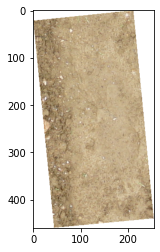

In [18]:
plt.imshow(cropped)